In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
import re
from glob import glob
import matplotlib.pyplot as plt

In [89]:
from CDDM import CDDM

In [90]:
tornado_path = os.path.abspath('../tornado')
sys.path.insert(0, tornado_path)

In [91]:
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

In [65]:
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa

In [67]:
from IPython.display import display, Markdown

In [92]:
plt.style.use('ggplot')

In [93]:
from importlib import reload
CDDM = reload(CDDM)

# Detection Delay and False Positive Rate Evaluation

In [95]:
######################################
##### BERNOULLI DATA STREAM CODE #####
######################################

def generate_data(n_samples, p, rate=0.5):
    # p = [ Pr(y=1|x=0), Pr(y=1|x=1) ]
    # rate is proportion of x=1 (rather than x=0)
    x = np.array([ np.random.choice(2, p=[1-rate, rate]) for i in range(n_samples) ])
    y = [ np.random.choice(2, p=[1-p[i], p[i]]) for i in x ]
    x = x.reshape(-1, 1)

    return x, y

class Experiment:
    
    pre_drift_n = 1000
    post_drift_n = 1000
    
    def __init__(self, probs, detector, model, rates, parameter=None):
        # probs = [a,b,c,d]
        # Before drift:
        # P(1|0) = a
        # P(1|1) = b
        # After drift:
        # P(1|0) = c
        # P(1|1) = d
        self.probs = probs
        self.detector = detector
        self.model = model
        self.result = None
        self.rates = rates
        self.parameter = parameter
        
    def run_experiment(self):
        x1, y1 = generate_data(Experiment.pre_drift_n, self.probs[:2], self.rates[0])
        x2, y2 = generate_data(Experiment.post_drift_n, self.probs[2:], self.rates[1])
        # return either none or the point of detection
        model = self.model
        if type(model)==str:
            model = eval(model)()
        detector = self.detector
        if type(detector)==str:
            detector = eval(detector)()
        monitor = []
        # Calibrate the detector
        for i in range(len(x1)):
            y_ = y1[i: i+1]
            x_ = x1[i: i+1]
            model.partial_fit(x_, y_, classes=[0,1])
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
        monitor = []
        for i in range(len(x2)):
            y_ = y2[i: i+1]
            x_ = x2[i: i+1]
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
            
            if drift_status:
                self.result = i+1
                return i
        
        return
    
    def get_result_row(self):
        return pd.DataFrame({'Experiment': [f'{self.detector} + {self.model}'],
                            'Outcome': [self.result],
                           'Parameter': [self.parameter]})
    
class RepeatedExperiment:
    
    n_repeats = 1
    
    def __init__(self, probs, detector, model, rates):
        
        self.experiments = []
        self.detector = detector
        self.probs = probs
        self.model = model
        self.rates = rates
        
    def run_experiments(self):
        for i in range(RepeatedExperiment.n_repeats):
            new_experiment = Experiment(self.probs, self.detector, self.model, self.rates)
            new_experiment.run_experiment()
            self.experiments.append(new_experiment)
        
    def get_summary(self):
        results = [ exp.result for exp in self.experiments ]
        detections = [ i for i in results if i ]
        latency = np.mean(detections)
        try:
            recall = len(detections) / len(results)
        except:
            recall = 0
        return {'latency': latency, 
                'detection_rate': recall }
    
class MultiDetectorExperiments:
    
    def __init__(self, probs, detectors, models, rates=[0.5, 0.5]):
        self.probs = probs
        self.detectors = detectors
        self.models = models
        self.repeated_experiments = {}
        self.rates = rates
        
    def run_experiments(self):
        for detector in self.detectors:
            for model in self.models:
                new_experiments = RepeatedExperiment(self.probs, eval(detector), eval(model), self.rates)
                new_experiments.run_experiments()
                name = f'{model} + {detector}'
                self.repeated_experiments[name] = new_experiments
        
    def results_table(self):
        table = pd.DataFrame(columns=['Experiment', 'Latency', 'Detection Rate'])
        i = 0
        for (name, repeated_experiment) in self.repeated_experiments.items():
            summary = repeated_experiment.get_summary()
            latency, detection_rate = summary['latency'], summary['detection_rate']
            table.loc[i] = [name, latency, detection_rate]
            i += 1
        return table

In [96]:
class NB: # Simple Naive Bayes Learner
    def __init__(self):
        self.counts = { 0: np.array([1,1]), 1: np.array([1,1])}
    def partial_fit(self, x, y, classes=None):
        for x_, y_ in zip(x, y):
            self.counts[x_[0]][y_] += 1
        return self
    def predict_proba(self, x):
        ret = []
        for x_ in x:
            while not type(x_)==np.int64 and not type(x_)==int:
                x_ = x_[0]
            ret.append( self.counts[x_]/np.sum(self.counts[x_]) )
        ret = np.array(ret)
        return ret
    def predict(self, x):
        probs = self.predict_proba(x)
        ret = [ max([0,1], key=lambda x: line[x]) for line in probs ]
        return ret

In [97]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NB']

def experiment(probs, rates, param=None, repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, param)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

## Detection Delay varying with Noise

In [121]:
def delay_experiment(epsilon):
    probs = [1-epsilon, epsilon, epsilon, 1-epsilon]
    rates = [0.5, 0.5]
    return experiment(probs, rates, param=epsilon, repeats=100)

def latency_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.3, num=20):
        results = results.append(delay_experiment(epsilon))
    return results

latency = latency_experiments()

In [122]:
# Tidy data so that seaborn can plot it
latency_ = latency[~(latency['Outcome'].isna())]
latency_['Outcome'] = latency_['Outcome'].astype('int')
latency_['Experiment'] = latency_['Experiment'].astype('category')

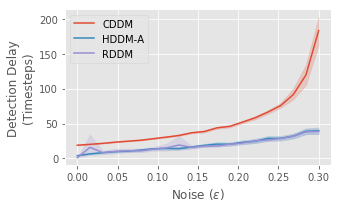

In [167]:
# Create plot
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', height=3, aspect=1, data=latency_)
g.set(xlabel='Noise ($\epsilon$)', ylabel='Detection Delay\n(Timesteps)')#, title='CDDM Detection Delay vs Noise');
plt.gca().legend(loc='upper left', labels=('CDDM', 'HDDM-A', 'RDDM'))
g._legend.remove()
plt.tight_layout()
plt.savefig('delay_noise_plt.pdf');

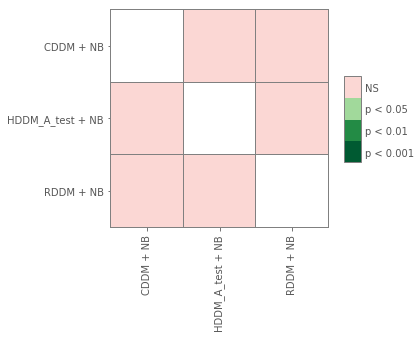

In [174]:
# Run Nemenyi post-hoc test
pc = sp.posthoc_nemenyi(latency_, val_col='Parameter', group_col='Experiment')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);

## Effect of Noise on False Positive Rate

In [104]:
def high_noise_experiment(epsilon):
    probs = [0.5-epsilon, 0.5+epsilon, 0.5-epsilon, 0.5+epsilon]
    rates = [0.5, 0.5]
    return experiment(probs, rates, param=epsilon, repeats=100)

def high_noise_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=10):
        results = results.append(high_noise_experiment(epsilon))
    return results

high_noise = high_noise_experiments()

In [105]:
post_drift_n = 1000

def get_fp_df(results):
    ret = results.copy()
    ret['Outcome'] = ret['Outcome'].apply(lambda x: 0 if x==None else 1/x)
    return ret

def get_fp_rate_df(results):
    experiments = list(results.Experiment.unique())
    fp_df = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    i = 1
    for exp in results.Experiment.unique():
        for param in results.Parameter.unique():
            hn_i = results[(results.Experiment==exp) & (results.Parameter==param)]
            positives = [ i for i in hn_i.Outcome if i!=None]
            fp_df.loc[i, :] = [exp, param, len(positives)/len(hn_i)]
            i += 1
    fp_df['Experiment'] = fp_df['Experiment'].astype('category')
    fp_df['Parameter'] = fp_df['Parameter'].astype('float')
    fp_df['Outcome'] = fp_df['Outcome'].astype('float')
    return fp_df

In [106]:
high_noise_2 = get_fp_df(high_noise)

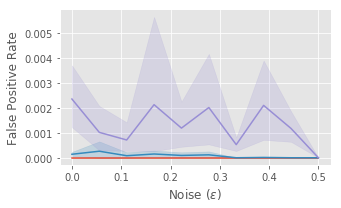

In [168]:
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', height=3, aspect=1, data=high_noise_2)#, legend=False)
g.set(xlabel='Noise ($\epsilon$)', ylabel='False Positive Rate')#, title='False Positives vs Noise Level');
# plt.gca().legend(loc='upper right')
g._legend.remove()
plt.tight_layout()
plt.savefig('noise_fp_plt.pdf');

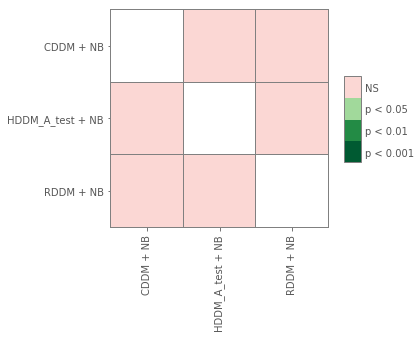

In [176]:
pc = sp.posthoc_nemenyi(high_noise_2, val_col='Parameter', group_col='Experiment')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);

## Effect of Noise on False Positive Rate from Virtual Drift

In [112]:
def vd_experiment(epsilon):
    probs = [0, 1-epsilon, 0, 1-epsilon]
    rates = [0.1, 0.9]
    return experiment(probs, rates, param=epsilon, repeats=100)

def vd_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.49, num=10):
        results = results.append(vd_experiment(epsilon))
    return results

vd_df = vd_experiments()

In [113]:
vd_fps = get_fp_df(vd_df)

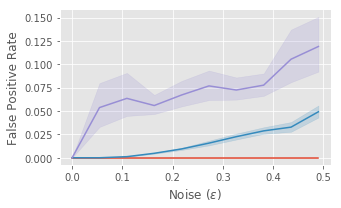

In [169]:
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', height=3, aspect=1, data=vd_fps)
g.set(xlabel='Noise ($\epsilon$)', ylabel='False Positive Rate')#, title='False Positives vs Virtual Drift');
g._legend.remove()
plt.tight_layout()
plt.savefig('virtual_drift_plt.pdf');

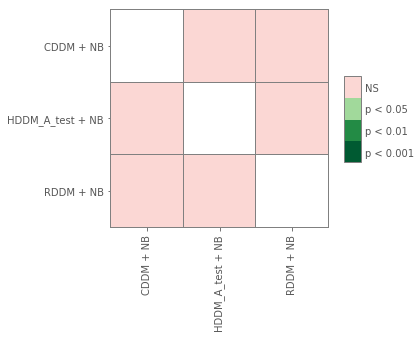

In [175]:
pc = sp.posthoc_nemenyi(vd_fps, val_col='Parameter', group_col='Experiment')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);

# Benchmark Datasets

In [49]:
def create_datastreams(path, stream_objects, n_copies, concept_length=20000):
    '''
    Instantiate n_copies instances of every stream generator in stream_objects.
    These instances are recorded as arffs under path.
    '''
    
    # dictionary to record the locations of the drifts for each stream
    drift_locations = {} 
    
    for stream_obj in stream_objects:
        
        # give this stream its own directory for its data
        stream_name = stream_obj.get_class_name()
        stream_path = os.path.join(path, stream_name)
        if not os.path.exists(stream_path):
            os.makedirs(stream_path)
            
        # create n copies of the stream
        for i in range(n_copies):
            copy_path = os.path.join(stream_path, f'{stream_name}_{i}')
            stream_obj_i = stream_obj(concept_length=concept_length, random_seed=i)
            stream_obj_i.generate(copy_path)
            
        # add entry to drift_locations
        n_drifts = eval(f'stream_obj_i._{stream_name}__NUM_DRIFTS') # double underscore name mangling
        stream_drift_locs = [ (i+1)*concept_length for i in range(n_drifts) ]
        drift_locations[stream_name] = stream_drift_locs
    
    return drift_locations

In [50]:
benchmark_path = os.path.abspath('./benchmark_data')
benchmark_streams = [SINE1, CIRCLES, MIXED, LEDConceptDrift]

benchmark_drift_locs = create_datastreams(benchmark_path, benchmark_streams, 10)

You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in /Users/hamishh/Documents/CDDM_SIGIR20/benchmark_data/SINE1/SINE1_0.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in /Users/hamishh/Documents/CDDM_SIGIR20/benchmark_data/SINE1/SINE1_1.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in /Users/hamishh/Documents/CDDM_SIGIR20/benchmark_data/SINE1/SINE1_2.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in /Users/hamishh/Documents/CDDM_SIGIR20/benchmark_data/SINE1/SINE1_3.ar

In [643]:
# Test
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

def run_tornado_experiment(dataset_name):
    
    # for example, dataset_name='circles_0'
    
    # 1. Creating a project
    project = Project("benchmark_experiments", dataset_name)
    
    # 2. Loading an arff file
    dataset_type = dataset_name.rstrip('0123456789_')
    dataset_path = os.path.abspath(f'benchmark_data/{dataset_type}/{dataset_name}.arff')
    labels, attributes, stream_records = ARFFReader.read(dataset_path)
    attributes_scheme = AttributeScheme.get_scheme(attributes)

    # 3. Initializing a Classifier-Detector Pairs
    pairs = [
             [NaiveBayes(labels, attributes_scheme['nominal']), CDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), RDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), HDDM_A_test()],
             [Perceptron(labels, attributes_scheme['numeric']), CDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), RDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), HDDM_A_test()]
            ]

    # 4. Creating a color set for plotting results
    colors = [Color.Indigo[1], Color.Blue[1], Color.Green[1], Color.Lime[1], Color.Yellow[1],
              Color.Amber[1], Color.Orange[1]][:len(pairs)]

    # 5. Defining actual locations of drifts, acceptance delay interval, and vector of weights
    actual_drift_points = [20000, 40000, 60000, 80000]
    drift_acceptance_interval = 250
    w_vec = [1, 1, 1, 1, 1, 1]

    # 6. Creating a Prequential Evaluation Process
    prequential = PrequentialMultiPairs(pairs, attributes, attributes_scheme,
                                        actual_drift_points, drift_acceptance_interval,
                                        w_vec, project, color_set=colors, legend_param=False)

    prequential.run(stream_records, 1)

In [43]:
for i, path in enumerate(glob('./benchmark_data/_synthetic/*/*.arff')):
    dataset_name = re.match(r'.*/([\w\d]+).arff', path).group(1)
    print(i, dataset_name)
    run_tornado_experiment(dataset_name)

0 led_2


NameError: name 'run_tornado_experiment' is not defined

In [46]:
def parse_results(path):
    path = os.path.abspath(path)
    dataset_name = re.match('^.*/(.*?).txt$', path).group(1)
    with open(path) as f:
        lines = f.read().split('\n')
    headers = lines[0].rstrip(']').lstrip('[')
    headers = [ header.lstrip() for header in headers.split(',') ]
    results = pd.DataFrame(columns=headers)
    i = 1
    for line in lines[1:]:
        fields = line.split('\t')
        if fields==['']:
            continue
        results.loc[i, :] = fields
        i += 1
        
    results['Dataset'] = dataset_name
        
    # Parse "Drift Detector Stats"
    total_delay = []
    tp = []
    location_of_last_detection = []
    fp, fn = [], []
    for i in range(len(results)):
        temp = eval(results.loc[i+1, 'Drift Detector Stats'])
        tdi, [lldi, tpi], fpi, fni = temp
        total_delay.append(tdi)
        tp.append(tpi)
        location_of_last_detection.append(lldi)
        fp.append(fpi)
        fn.append(fni)
    results['Total Delay'] = total_delay
    results['TP'] = tp
    results['FN'] = fn
    results['FP'] = fp
    
    # Split up name
    models = []
    detectors = []
    for i in range(len(results)):
        name = results.loc[i+1, 'Name']
        n_match = re.match('([\w\s]+) \+ ([\w\.]+)', name)
        models.append( n_match.group(1) )
        detectors.append( n_match.group(2) )
    results['Model'] = models
    results['Detector'] = detectors
    
    # Get wanted columns in right order
    results = results[['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Avg. Error-rate', 'Avg. Total Memory', 'Avg. Total Runtime', 'Total Delay']]
    results.columns = ['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay']
        
    return results

In [79]:
results = pd.DataFrame(columns=['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay'])

for i, path in enumerate(glob('./benchmark_experiments/*/*/*.txt')):
    results = results.append(parse_results(path))
results

,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,mixed_3,CDDM,NAIVE BAYES,4,0,0,0.0,45.77,13322.25,327
2,mixed_3,RDDM,NAIVE BAYES,4,0,0,14.56,103.1,377.44,404
3,mixed_3,HDDM.A.test,NAIVE BAYES,4,0,0,14.69,40.49,513.05,269
4,mixed_3,CDDM,PERCEPTRON,4,0,0,0.0,15.76,13134.9,273
5,mixed_3,RDDM,PERCEPTRON,4,0,0,18.3,73.1,259.19,474
6,mixed_3,HDDM.A.test,PERCEPTRON,4,0,1,18.360000000000003,10.49,382.53,250
1,mixed_4,CDDM,NAIVE BAYES,4,0,0,0.0,45.77,13294.3,339
2,mixed_4,RDDM,NAIVE BAYES,4,0,0,14.39,103.1,373.98,398
3,mixed_4,HDDM.A.test,NAIVE BAYES,4,0,0,14.48,40.49,513.61,225
4,mixed_4,CDDM,PERCEPTRON,4,0,0,0.0,15.75,13100.09,285


In [191]:
def get_the_data_table_ready_for_latex(results):
    
    latex_table = pd.DataFrame()
    
    ##########################################
    ###### Create the experiment column ######
    ##########################################
    
    def get_ds_name(str_):
        # get dataset name
        return re.match(r'([a-z]+).*', str_).group(1).upper()
    ds_names = results['Dataset'].apply(get_ds_name)
    
    det_names_map = {'HDDM.A.test': r'HDDM-A', 'CDDM': 'CDDM', 'RDDM': 'RDDM'}
    det_names = results['Detector'].map(det_names_map)
    
    model_names_map = {'NAIVE BAYES': 'NB', 'PERCEPTRON': 'PR'}
    model_names = results['Model'].map(model_names_map)
    
    exp_names = ds_names + '+' + det_names + '+' + model_names
    latex_table['Experiment'] = exp_names
    
    ##########################################
    ###### Precision and Recall         ######
    ##########################################
    
    # Calculate precision and recall
    tp = results['TP'].astype('float')
    fp = results['FP'].astype('float')
    fn = results['FN'].astype('float')
    prec = ( tp / (tp + fp) )
    prec = prec.map(lambda x: x if np.isfinite(x) else np.nan)
    rec = ( tp / (tp + fn) )
    latex_table['Prec'] = prec
    latex_table['Rec'] = rec
    
    latex_table['Mean Delay'] = results['Total Delay'].astype('float') / results['TP'].astype('float')

    # Copy over other metrics
    for i in ['Memory', 'Runtime', 'Total Delay']:
        latex_table[i] = results[i].astype('float')
        
    ##########################################
    ###### Mean and Standard Deviation  ######
    ##########################################
    
    means_table = pd.DataFrame(columns=latex_table.columns, 
                               index=latex_table['Experiment'].unique())
    for exp in latex_table['Experiment'].unique():
        this_exp = latex_table[ latex_table['Experiment']==exp ]
        
        for col in means_table.columns:
            
            if col=='Experiment':
                means_table.loc[exp, col] = exp
                continue
            
            col_vals = this_exp[col]
            
            mean = np.nanmean(col_vals)
            std = np.nanstd(col_vals)
            
#             if std==0:
#                 display(this_exp)
            
            entry = f'{mean:.2f} ({std:.2f})' if not np.isnan(mean) else '- (-)'
            means_table.loc[exp, col] = entry
        
    ##########################################
    ###### Print LaTeX and return table ######
    ##########################################
        
    print( means_table.to_latex(index=False) )
    
    return latex_table, means_table

In [192]:
latex_table, means_table = get_the_data_table_ready_for_latex(results);

\begin{tabular}{lllllll}
\toprule
        Experiment &         Prec &          Rec &       Mean Delay &         Memory &              Runtime &     Total Delay \\
\midrule
     MIXED+CDDM+NB &  1.00 (0.00) &  1.00 (0.00) &     86.83 (4.39) &   45.77 (0.00) &     13327.96 (72.02) &  347.30 (17.56) \\
     MIXED+RDDM+NB &  0.97 (0.10) &  1.00 (0.00) &     99.15 (4.10) &  103.10 (0.01) &        379.64 (4.18) &  396.60 (16.38) \\
   MIXED+HDDM-A+NB &  1.00 (0.00) &  1.00 (0.00) &    67.85 (11.76) &   40.49 (0.00) &        515.29 (2.51) &  271.40 (47.03) \\
     MIXED+CDDM+PR &  1.00 (0.00) &  1.00 (0.00) &     73.12 (6.13) &   15.76 (0.01) &    13234.50 (163.42) &  292.50 (24.52) \\
     MIXED+RDDM+PR &  0.91 (0.12) &  1.00 (0.00) &   121.50 (16.82) &   73.10 (0.00) &       252.06 (14.05) &  486.00 (67.28) \\
   MIXED+HDDM-A+PR &  0.91 (0.12) &  1.00 (0.00) &    87.58 (17.91) &   10.49 (0.00) &       383.95 (11.66) &  350.30 (71.65) \\
      SINE+CDDM+NB &  1.00 (0.00) &  1.00 (0.00) &    

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1426: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice


In [182]:
print( means_table.drop(columns=['Memory', 'Experiment']).to_latex() )

\begin{tabular}{lllll}
\toprule
{} &         Prec &          Rec &              Runtime &     Total Delay \\
\midrule
MIXED+CDDM+NB     &  1.00 (0.00) &  1.00 (0.00) &     13327.96 (72.02) &  347.30 (17.56) \\
MIXED+RDDM+NB     &  0.97 (0.10) &  1.00 (0.00) &        379.64 (4.18) &  396.60 (16.38) \\
MIXED+HDDM-A+NB   &  1.00 (0.00) &  1.00 (0.00) &        515.29 (2.51) &  271.40 (47.03) \\
MIXED+CDDM+PR     &  1.00 (0.00) &  1.00 (0.00) &    13234.50 (163.42) &  292.50 (24.52) \\
MIXED+RDDM+PR     &  0.91 (0.12) &  1.00 (0.00) &       252.06 (14.05) &  486.00 (67.28) \\
MIXED+HDDM-A+PR   &  0.91 (0.12) &  1.00 (0.00) &       383.95 (11.66) &  350.30 (71.65) \\
SINE+CDDM+NB      &  1.00 (0.00) &  1.00 (0.00) &    13285.65 (134.14) &  342.70 (29.05) \\
SINE+RDDM+NB      &  0.98 (0.06) &  1.00 (0.00) &        324.30 (3.24) &  410.70 (28.59) \\
SINE+HDDM-A+NB    &  0.87 (0.17) &  1.00 (0.00) &       440.97 (30.92) &  278.10 (30.47) \\
SINE+CDDM+PR      &  1.00 (0.00) &  1.00 (0.00) &     

# Post-hoc Tests

In [68]:
results = latex_table
results['Detector'] = results['Experiment'].apply(lambda x: 'RDDM' if 'RDDM' in x else 'CDDM' if 'CDDM' in x else 'HDDM-A')

In [74]:
means_table = results.copy()
means_table.groupby('Detector').mean()

,Prec,Rec,Memory,Runtime,Total Delay
Detector,,,,,
CDDM,0.759259,0.504167,52.702125,30956.36575,530.4125
HDDM-A,0.662932,0.737500,47.548125,1021.42800,454.8125
RDDM,0.578333,0.608333,110.169750,910.03250,571.4250


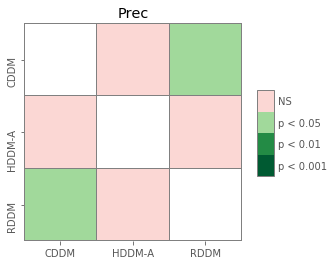

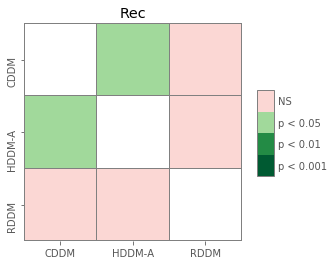

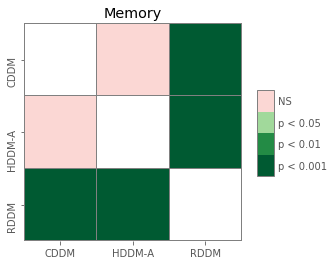

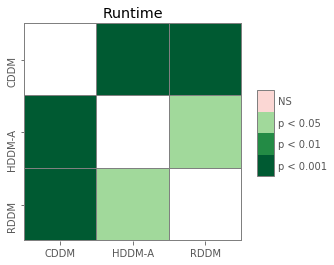

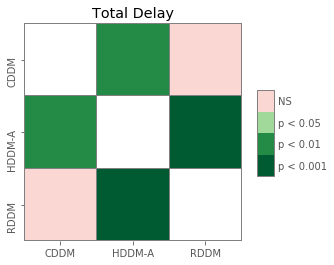

In [69]:
for col in results.columns[1:-1]:
    plt.figure()
#     display(Markdown('## '+col))
    pc = sp.posthoc_nemenyi(results, val_col=col, group_col='Detector')
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    plt.title(col)
    sp.sign_plot(pc, **heatmap_args);

In [75]:
pc

,CDDM,HDDM-A,RDDM
CDDM,-1.000000,0.006247,0.339721
HDDM-A,0.006247,-1.000000,0.000020
RDDM,0.339721,0.000020,-1.000000


# Referrals Data

In [43]:
# Test
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

def run_tornado_experiment(dataset_name):
    
    # for example, dataset_name='circles_0'
    
    # 1. Creating a project
    project = Project("referral_experiments", dataset_name)
    
    # 2. Loading an arff file
    dataset_type = dataset_name.rstrip('0123456789_')
    dataset_path = os.path.abspath(f'referral_data/{dataset_name}.arff')
    labels, attributes, stream_records = ARFFReader.read(dataset_path)
    attributes_scheme = AttributeScheme.get_scheme(attributes)

    # 3. Initializing a Classifier-Detector Pairs
    pairs = [
             [NaiveBayes(labels, attributes_scheme['nominal']), CDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), RDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), HDDM_A_test()],
             [Perceptron(labels, attributes_scheme['numeric']), CDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), RDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), HDDM_A_test()]
            ]

    # 4. Creating a color set for plotting results
    colors = [Color.Indigo[1], Color.Blue[1], Color.Green[1], Color.Lime[1], Color.Yellow[1],
              Color.Amber[1], Color.Orange[1]][:len(pairs)]

    # 5. Defining actual locations of drifts, acceptance delay interval, and vector of weights
    actual_drift_points = [2000, 4000, 6000, 8000]
    drift_acceptance_interval = 250
    w_vec = [1, 1, 1, 1, 1, 1]

    # 6. Creating a Prequential Evaluation Process
    prequential = PrequentialMultiPairs(pairs, attributes, attributes_scheme,
                                        actual_drift_points, drift_acceptance_interval,
                                        w_vec, project, color_set=colors, legend_param=False)

    prequential.run(stream_records, 1)

In [12]:
from glob import glob

0 referrals5
The project path "referral_experiments/referrals5/20200221_104614/" is created.
NB + CDDM [0.0, 10970.752, 381.99946796521544] [133, [8029, 4], 157, 0, 3.592, 3.967579803429544]
NB + RDDM [0.4375, 11342.576, 47248.6467048293] [231, [8087, 4], 0, 0, 64.0, 21.672027884051204]
NB + HDDM.A.test [0.4587, 11249.84, 31392.942387610674] [94, [8017, 4], 1, 0, 1.248, 37.3392851324752]
PR + CDDM [0.0, 3786.392, 16251.551811117679] [183, [8059, 4], 0, 0, 6.872, 2463.1765600061044]
PR + RDDM [0.2468, 3787.848, 25866.035044309683] [157, [8047, 4], 0, 0, 64.0, 20.253147231414914]
PR + HDDM.A.test [0.268, 3787.944, 25366.810762672685] [45, [8011, 4], 0, 0, 1.216, 50.47454359009862]
THE END

1 referrals9
The project path "referral_experiments/referrals9/20200221_110836/" is created.
NB + CDDM [0.0, 10970.784, 334.963965928182] [94, [8019, 4], 172, 0, 3.472, 3.084575990214944]
NB + RDDM [0.5054, 11192.592, 47215.098578482866] [264, [8045, 4], 0, 0, 64.048, 21.949175745248795]
NB + HDDM.A.t

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


NB + CDDM [0.0, 10970.72, 163.7583621777594] [44, [8014, 4], 147, 0, 3.152, 1.3434570282697678]
NB + RDDM [0.4795, 11161.84, 45426.45304242615] [203, [8048, 4], 0, 0, 64.048, 21.72164968214929]
NB + HDDM.A.test [0.4736, 11162.0, 46790.38103565108] [72, [8011, 4], 0, 0, 1.312, 54.33322465978563]
PR + CDDM [0.0, 3786.392, 19604.330734466203] [150, [8036, 4], 0, 0, 6.872, 2577.6995577616617]
PR + RDDM [0.2461, 3787.848, 28113.651141757146] [138, [8033, 4], 0, 0, 64.048, 20.141866174526513]
PR + HDDM.A.test [0.2495, 3787.88, 27209.249471896328] [40, [8008, 4], 0, 0, 1.312, 51.185076823458076]
THE END

4 referrals3
The project path "referral_experiments/referrals3/20200221_121718/" is created.
NB + CDDM [0.0, 10971.52, 1366.5054977172986] [82, [8036, 4], 174, 0, 5.512, 31.049075885675848]
NB + RDDM [0.5008, 11300.56, 51617.70393000916] [511, [8047, 3], 1, 1, 64.048, 22.391781210899353]
NB + HDDM.A.test [0.4992, 11332.464, 51152.115478529595] [271, [8009, 4], 0, 0, 1.312, 54.7590289497748]


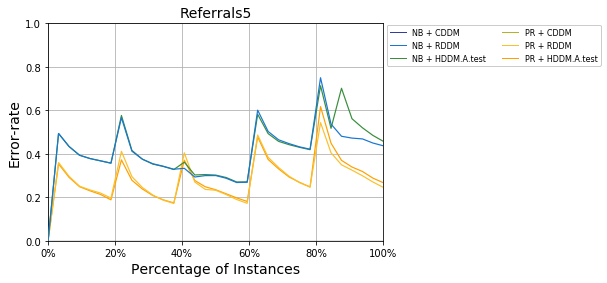

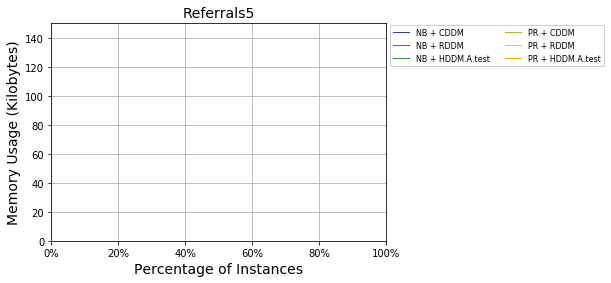

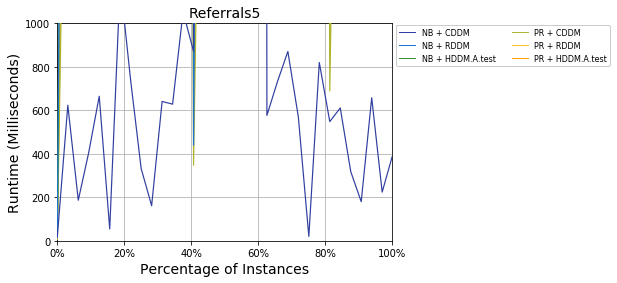

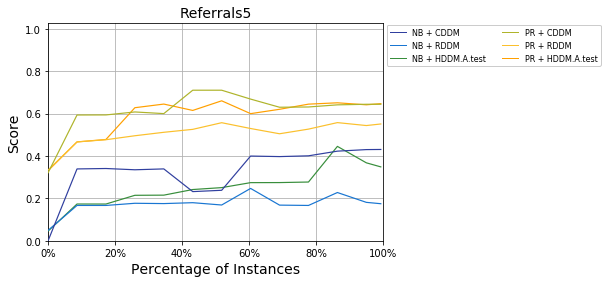

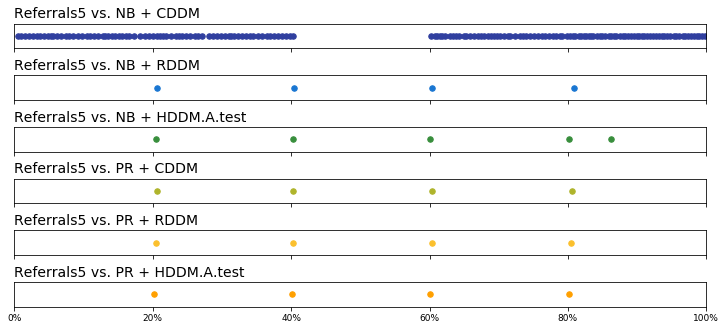

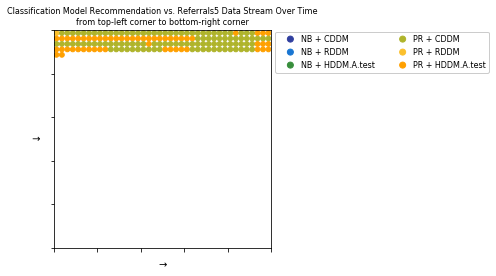

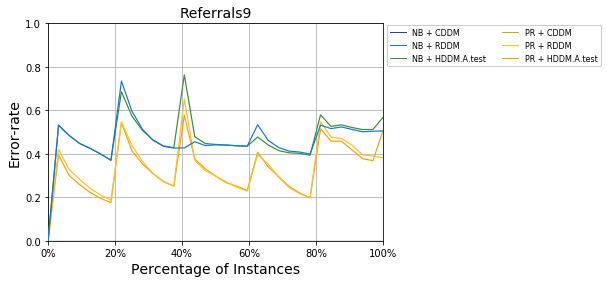

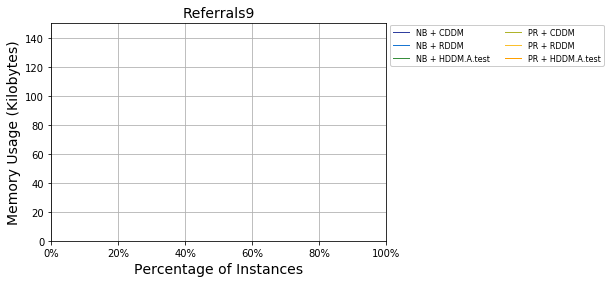

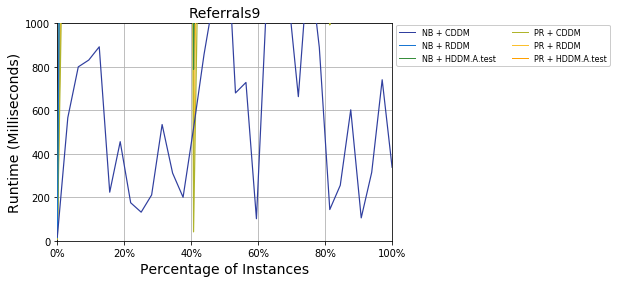

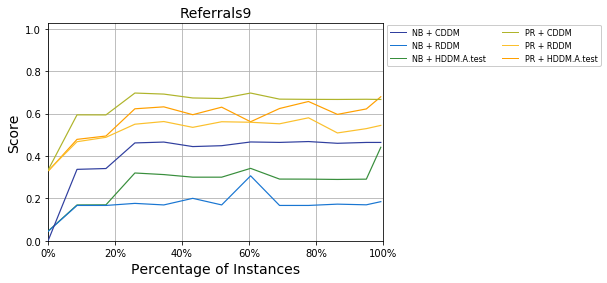

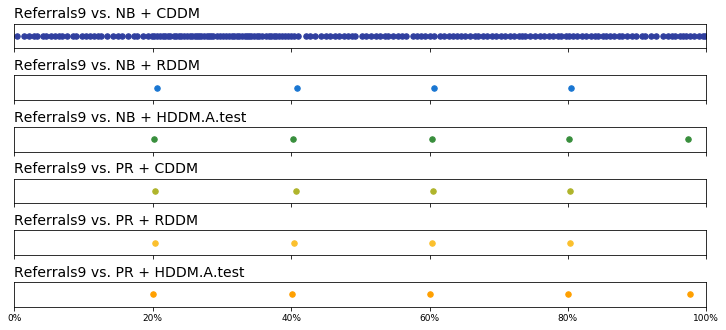

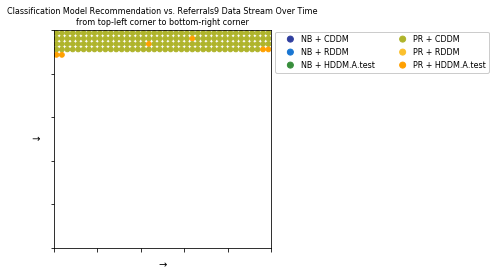

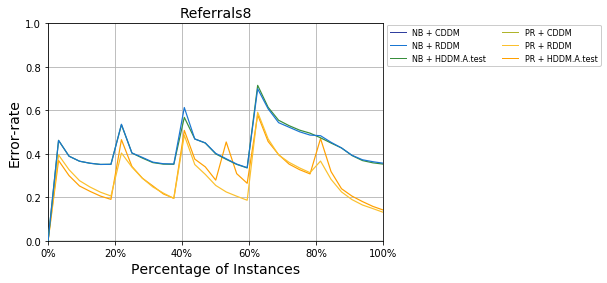

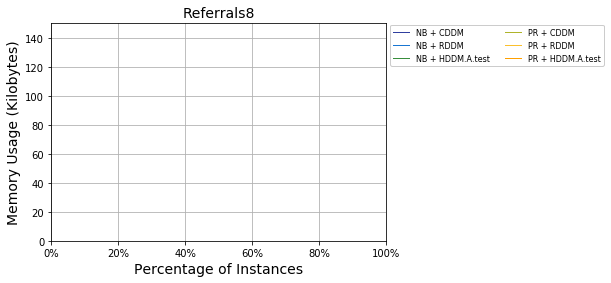

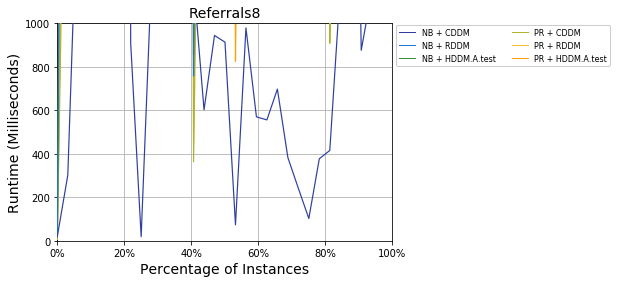

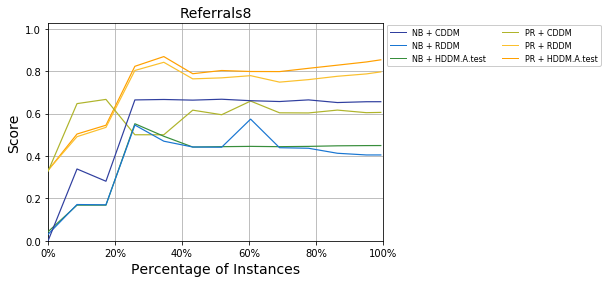

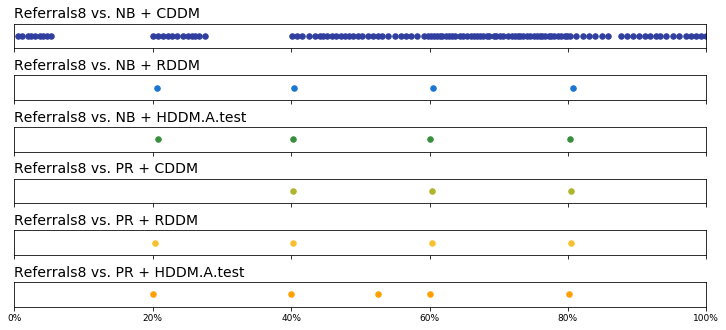

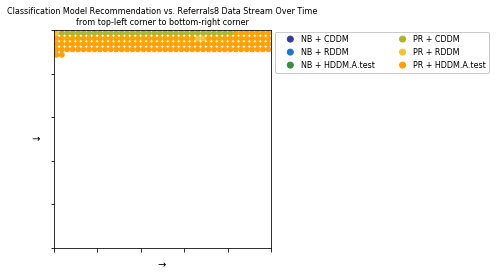

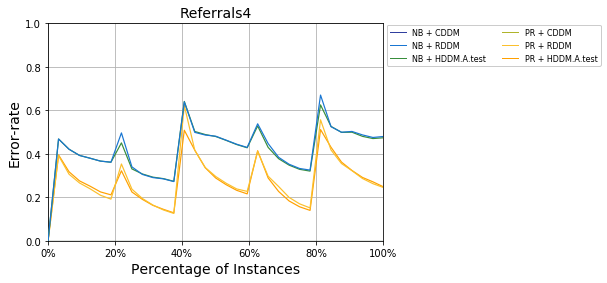

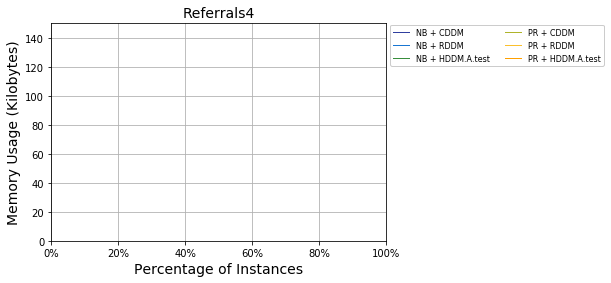

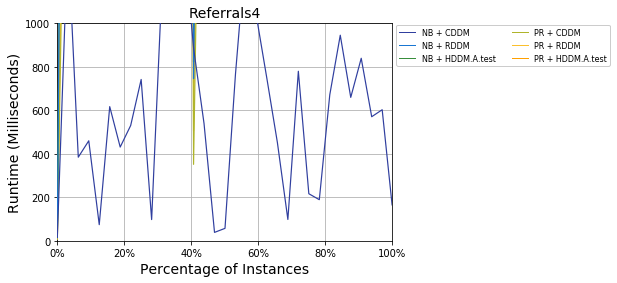

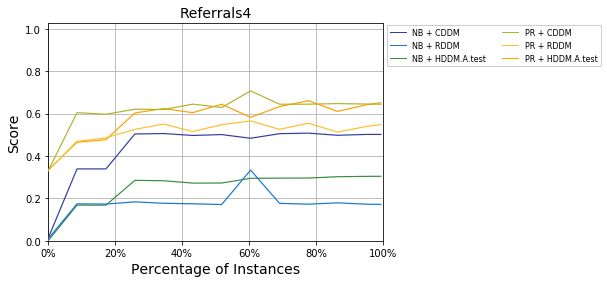

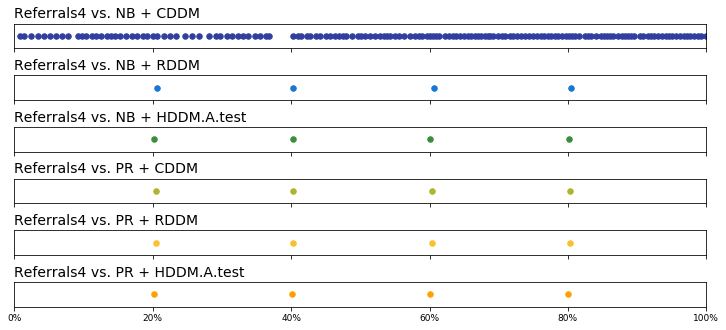

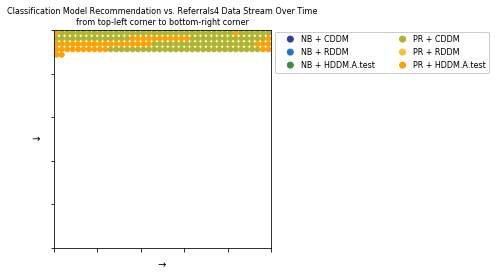

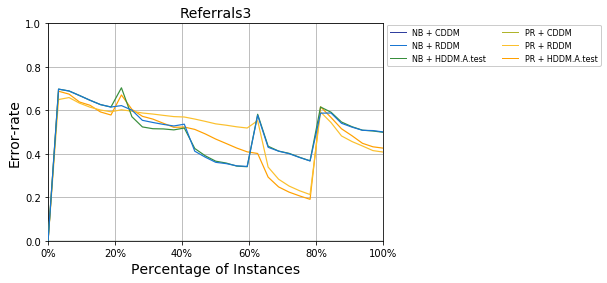

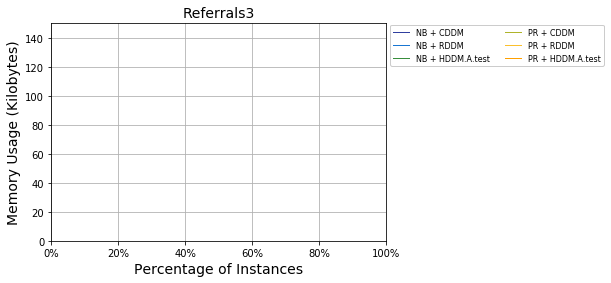

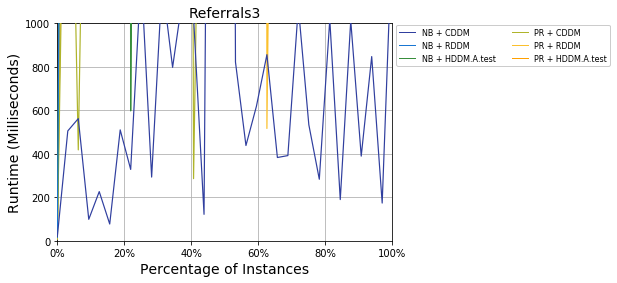

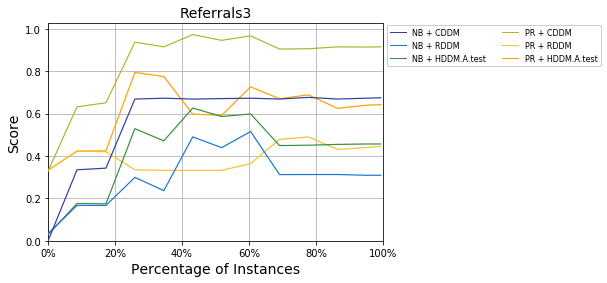

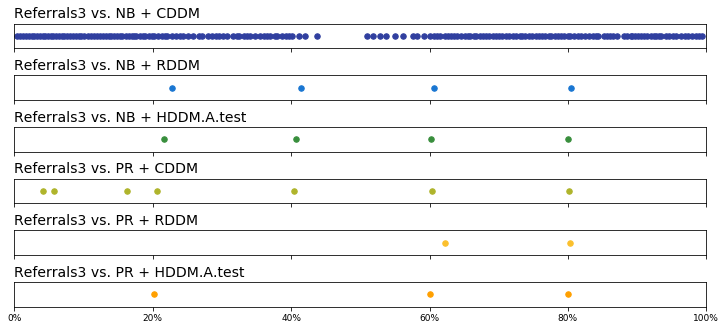

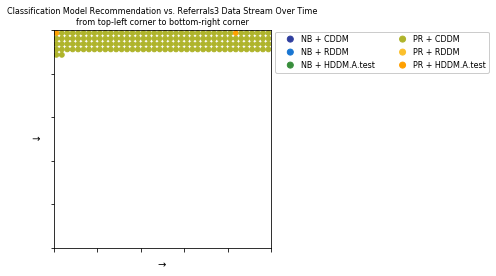

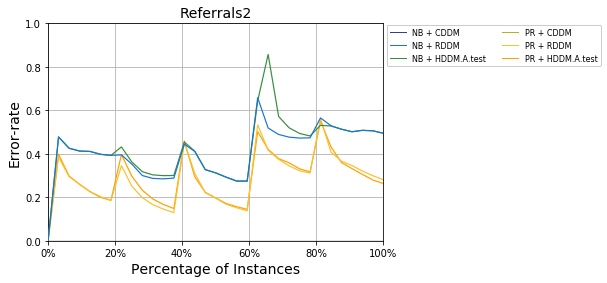

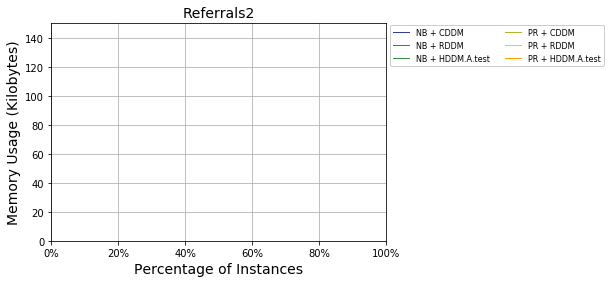

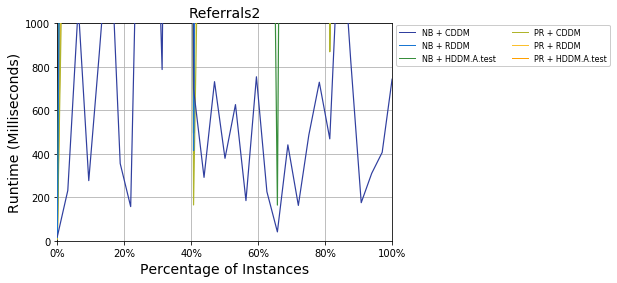

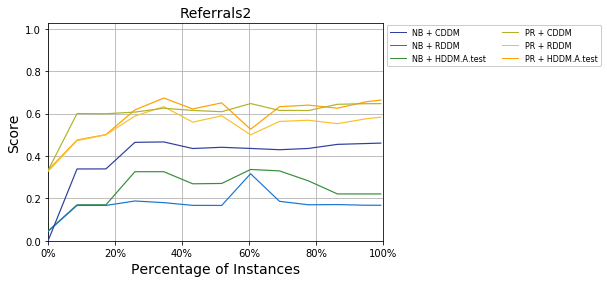

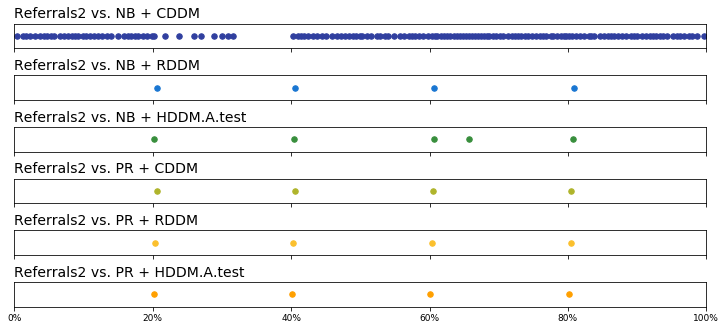

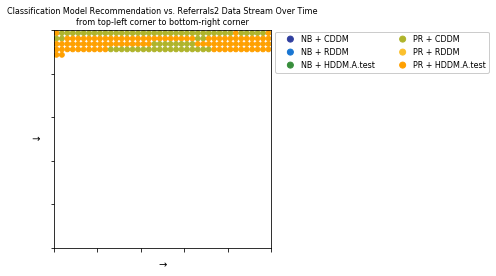

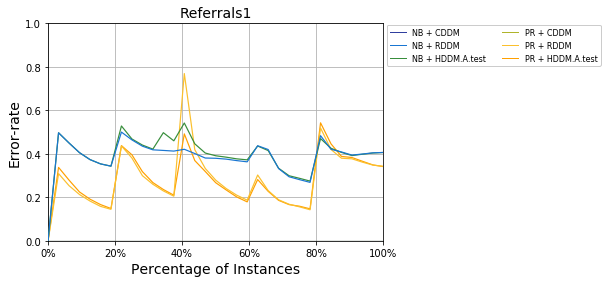

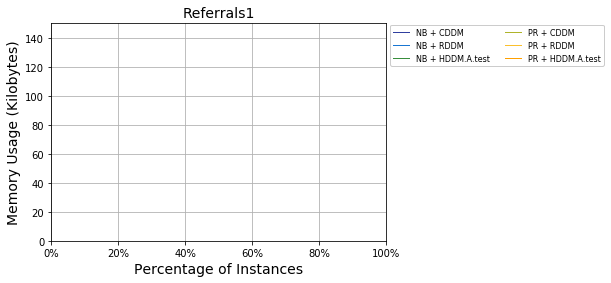

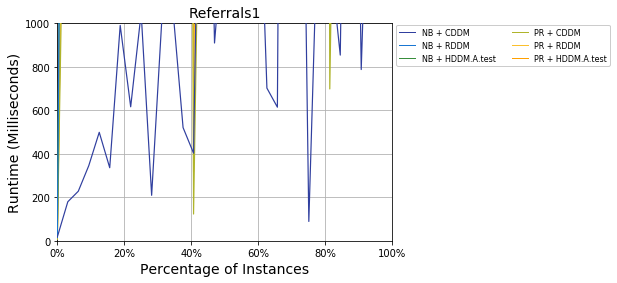

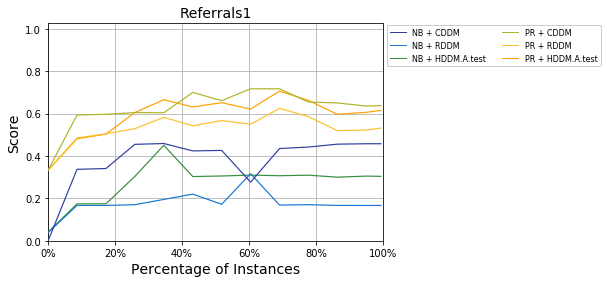

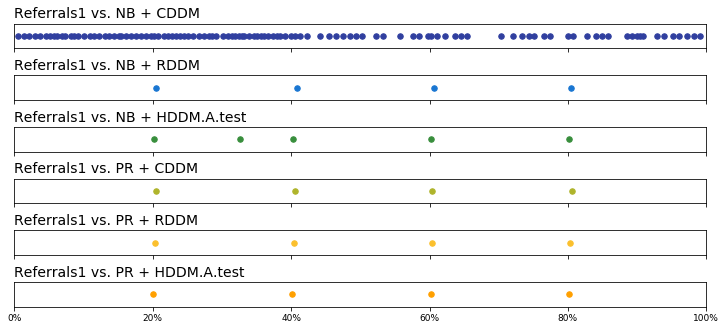

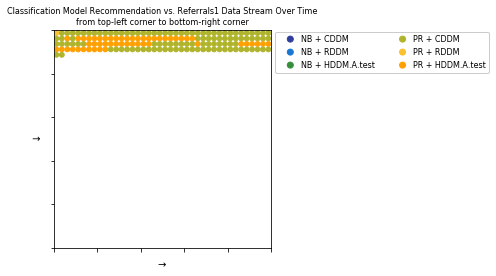

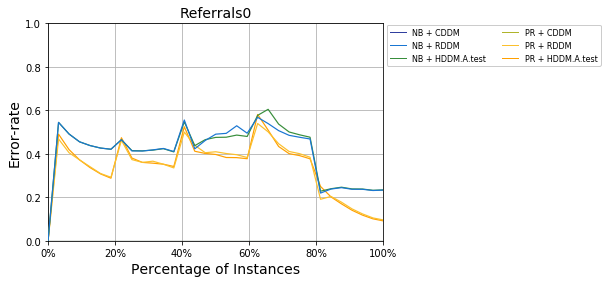

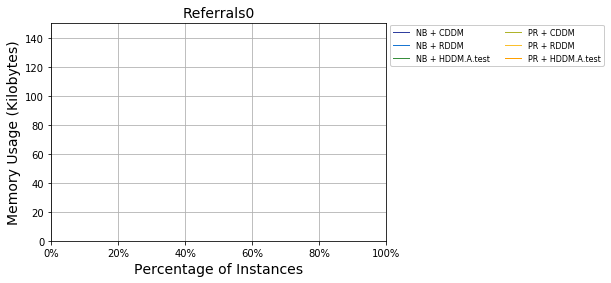

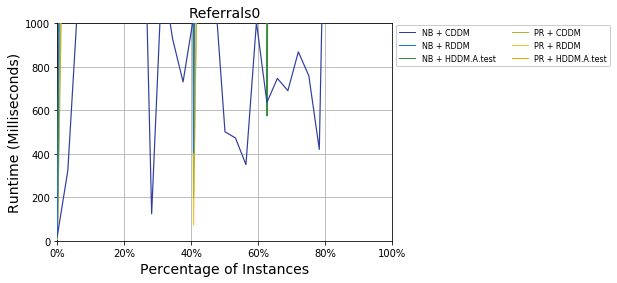

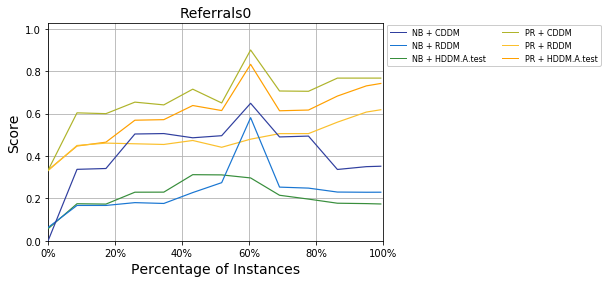

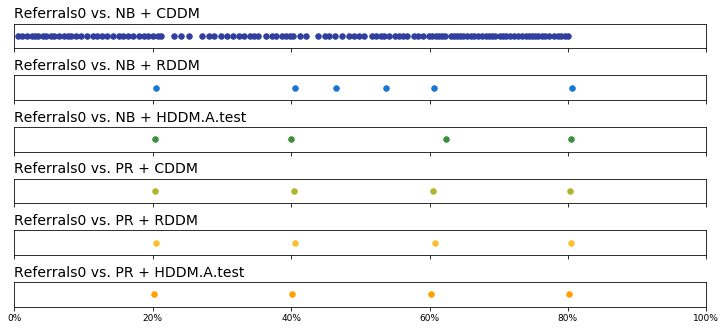

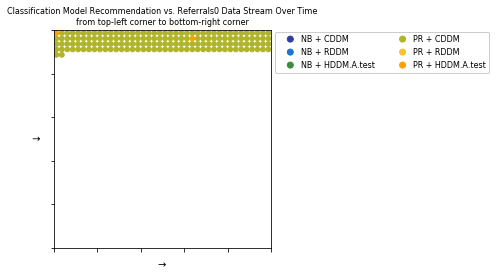

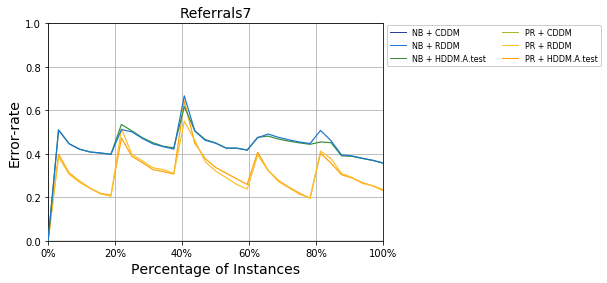

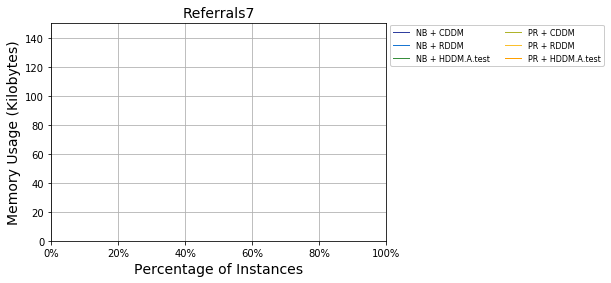

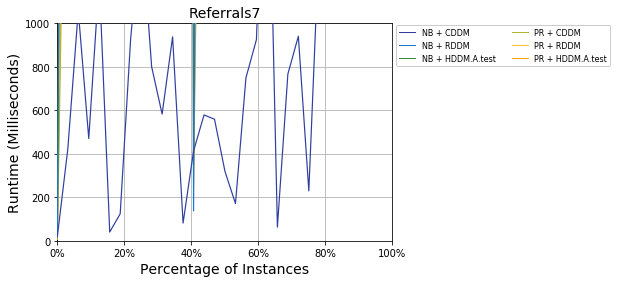

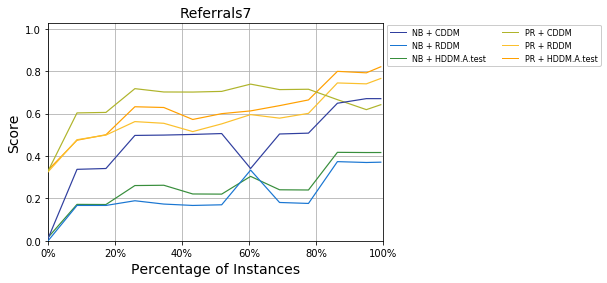

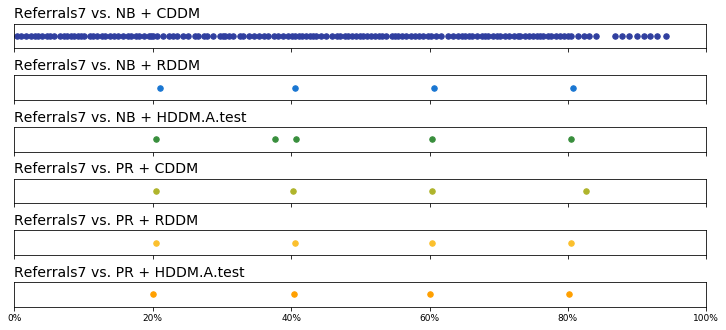

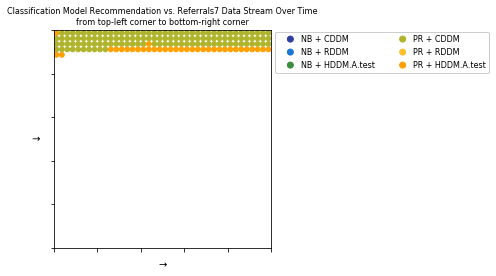

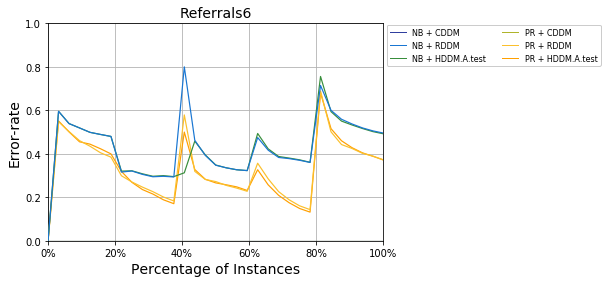

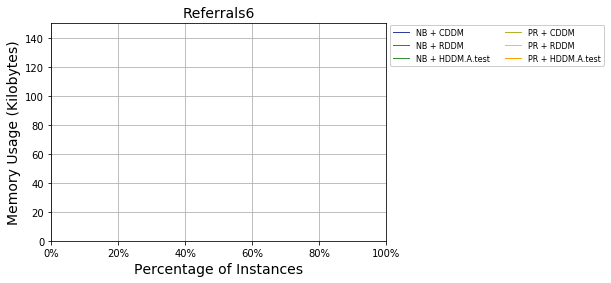

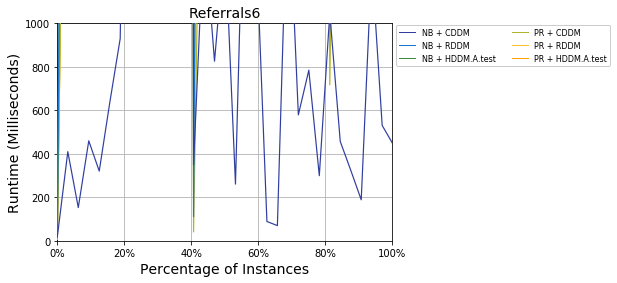

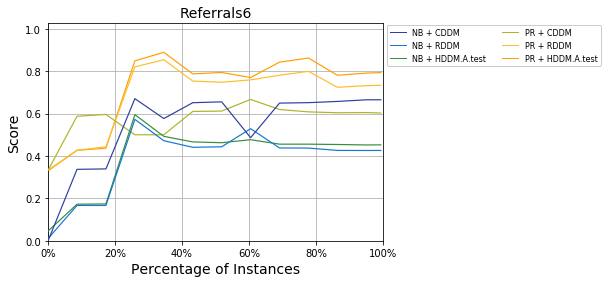

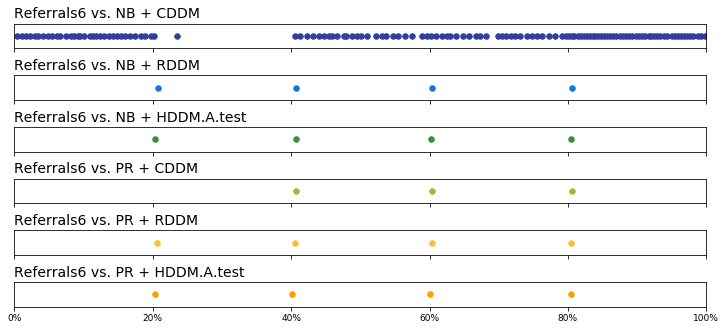

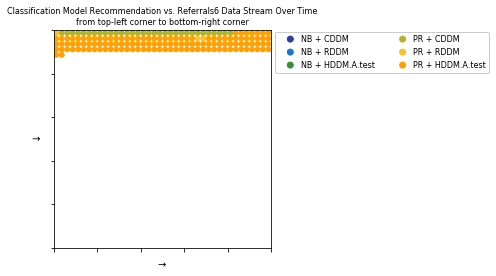

In [44]:
for i, path in enumerate(glob('./referral_data/*.arff')):
    dataset_name = re.match(r'.*/([\w\d]+).arff', path).group(1)
    print(i, dataset_name)
    run_tornado_experiment(dataset_name)

In [25]:
list(glob('./referral_experiments/&'))

[]

In [78]:
results = pd.DataFrame(columns=['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay'])

for i, path in enumerate(glob('./referral_experiments/*/*/*.txt')):
    print(path)
    results = results.append(parse_results(path))
results

./referral_experiments/referrals3/20200221_121718/referrals3.txt
./referral_experiments/referrals4/20200221_115438/referrals4.txt
./referral_experiments/referrals5/20200221_104614/referrals5.txt
./referral_experiments/referrals2/20200221_124122/referrals2.txt
./referral_experiments/referrals7/20200221_135051/referrals7.txt
./referral_experiments/referrals0/20200221_132722/referrals0.txt
./referral_experiments/referrals9/20200221_110836/referrals9.txt
./referral_experiments/referrals8/20200221_113109/referrals8.txt
./referral_experiments/referrals1/20200221_130429/referrals1.txt
./referral_experiments/referrals6/20200221_141513/referrals6.txt


,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,referrals3,CDDM,NAIVE BAYES,4,0,174,0.0,10979.59,1118.22,82
2,referrals3,RDDM,NAIVE BAYES,3,1,1,51.559999999999995,11171.89,25226.91,511
3,referrals3,HDDM.A.test,NAIVE BAYES,4,0,0,51.7,11106.97,23742.95,271
4,referrals3,CDDM,PERCEPTRON,4,0,3,0.0,3793.08,8714.7,158
5,referrals3,RDDM,PERCEPTRON,2,2,0,51.07000000000001,3850.16,29858.23,752
6,referrals3,HDDM.A.test,PERCEPTRON,3,1,0,49.58,3788.87,17630.12,285
1,referrals4,CDDM,NAIVE BAYES,4,0,147,0.0,10976.7,775.46,44
2,referrals4,RDDM,NAIVE BAYES,4,0,0,42.66,11179.04,21607.19,203
3,referrals4,HDDM.A.test,NAIVE BAYES,4,0,0,42.58,11118.85,22064.08,72
4,referrals4,CDDM,PERCEPTRON,4,0,0,0.0,3793.13,9975.5,150


In [79]:
def get_the_data_table_ready_for_latex(results):
    
    latex_table = pd.DataFrame()
    
    ##########################################
    ###### Create the experiment column ######
    ##########################################
    
    def get_ds_name(str_):
        # get dataset name
        return re.match(r'([a-z]+).*', str_).group(1).upper()
    ds_names = results['Dataset'].apply(get_ds_name)
    
    det_names_map = {'HDDM.A.test': r'HDDM-A', 'CDDM': 'CDDM', 'RDDM': 'RDDM'}
    det_names = results['Detector'].map(det_names_map)
    
    model_names_map = {'NAIVE BAYES': 'NB', 'PERCEPTRON': 'PR'}
    model_names = results['Model'].map(model_names_map)
    
    exp_names = ds_names + '+' + det_names + '+' + model_names
    latex_table['Experiment'] = exp_names
    
    ##########################################
    ###### Precision and Recall         ######
    ##########################################
    
    # Calculate precision and recall
    tp = results['TP'].astype('float')
    fp = results['FP'].astype('float')
    fn = results['FN'].astype('float')
    prec = ( tp / (tp + fp) )
    prec = prec.map(lambda x: x if np.isfinite(x) else np.nan)
    rec = ( tp / (tp + fn) )
    latex_table['Prec'] = prec
    latex_table['Rec'] = rec

    # Copy over other metrics
    for i in ['Memory', 'Runtime', 'Total Delay']:
        latex_table[i] = results[i].astype('float')
        
    ##########################################
    ###### Mean and Standard Deviation  ######
    ##########################################
    
    means_table = pd.DataFrame(columns=latex_table.columns, 
                               index=latex_table['Experiment'].unique())
    for exp in latex_table['Experiment'].unique():
        this_exp = latex_table[ latex_table['Experiment']==exp ]
        
        for col in means_table.columns:
            
            if col=='Experiment':
                means_table.loc[exp, col] = exp
                continue
            
            col_vals = this_exp[col]
            
            mean = np.nanmean(col_vals)
            std = np.nanstd(col_vals)
            
#             if std==0:
#                 display(this_exp)
            
            entry = f'{mean:.2f} ({std:.2f})' if not np.isnan(mean) else '- (-)'
            means_table.loc[exp, col] = entry
        
    ##########################################
    ###### Print LaTeX and return table ######
    ##########################################
        
    print( means_table.to_latex(index=False) )
    
    return latex_table, means_table

In [80]:
latex_table, means_table = get_the_data_table_ready_for_latex(results);

\begin{tabular}{llllll}
\toprule
          Experiment &         Prec &          Rec &            Memory &             Runtime &      Total Delay \\
\midrule
   REFERRALS+CDDM+NB &  0.03 (0.00) &  1.00 (0.00) &   10985.27 (9.37) &   2470.80 (1735.06) &    83.90 (27.47) \\
   REFERRALS+RDDM+NB &  0.94 (0.12) &  0.97 (0.07) &   11165.29 (9.48) &  23285.42 (1478.70) &   272.10 (84.48) \\
 REFERRALS+HDDM-A+NB &  0.90 (0.10) &  1.00 (0.00) &  11100.82 (11.76) &  22340.01 (1760.75) &   165.70 (79.55) \\
   REFERRALS+CDDM+PR &  0.93 (0.14) &  0.93 (0.11) &    3793.13 (0.02) &  10462.15 (1766.30) &   235.50 (93.85) \\
   REFERRALS+RDDM+PR &  1.00 (0.00) &  0.95 (0.15) &    3850.19 (0.05) &  14304.45 (5188.00) &  222.90 (179.04) \\
 REFERRALS+HDDM-A+PR &  0.96 (0.08) &  0.97 (0.07) &    3788.70 (0.07) &  12737.93 (1678.21) &    73.20 (72.44) \\
\bottomrule
\end{tabular}



In [81]:
print( means_table.drop(columns=['Memory', 'Experiment']).to_latex() )

\begin{tabular}{lllll}
\toprule
{} &         Prec &          Rec &             Runtime &      Total Delay \\
\midrule
REFERRALS+CDDM+NB   &  0.03 (0.00) &  1.00 (0.00) &   2470.80 (1735.06) &    83.90 (27.47) \\
REFERRALS+RDDM+NB   &  0.94 (0.12) &  0.97 (0.07) &  23285.42 (1478.70) &   272.10 (84.48) \\
REFERRALS+HDDM-A+NB &  0.90 (0.10) &  1.00 (0.00) &  22340.01 (1760.75) &   165.70 (79.55) \\
REFERRALS+CDDM+PR   &  0.93 (0.14) &  0.93 (0.11) &  10462.15 (1766.30) &   235.50 (93.85) \\
REFERRALS+RDDM+PR   &  1.00 (0.00) &  0.95 (0.15) &  14304.45 (5188.00) &  222.90 (179.04) \\
REFERRALS+HDDM-A+PR &  0.96 (0.08) &  0.97 (0.07) &  12737.93 (1678.21) &    73.20 (72.44) \\
\bottomrule
\end{tabular}



In [15]:
def parse_results(path):
    path = os.path.abspath(path)
    dataset_name = re.match('^.*/(.*?).txt$', path).group(1)
    with open(path) as f:
        lines = f.read().split('\n')
    headers = lines[0].rstrip(']').lstrip('[')
    headers = [ header.lstrip() for header in headers.split(',') ]
    results = pd.DataFrame(columns=headers)
    i = 1
    for line in lines[1:]:
        fields = line.split('\t')
        if fields==['']:
            continue
        results.loc[i, :] = fields
        i += 1
        
    results['Dataset'] = dataset_name
        
    # Parse "Drift Detector Stats"
    total_delay = []
    tp = []
    location_of_last_detection = []
    fp, fn = [], []
    for i in range(len(results)):
        temp = eval(results.loc[i+1, 'Drift Detector Stats'])
        tdi, [lldi, tpi], fpi, fni = temp
        total_delay.append(tdi)
        tp.append(tpi)
        location_of_last_detection.append(lldi)
        fp.append(fpi)
        fn.append(fni)
    results['Total Delay'] = total_delay
    results['TP'] = tp
    results['FN'] = fn
    results['FP'] = fp
    
    # Split up name
    models = []
    detectors = []
    for i in range(len(results)):
        name = results.loc[i+1, 'Name']
        n_match = re.match('([\w\s]+) \+ ([\w\.]+)', name)
        models.append( n_match.group(1) )
        detectors.append( n_match.group(2) )
    results['Model'] = models
    results['Detector'] = detectors
    
    # Get wanted columns in right order
    results = results[['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Avg. Error-rate', 'Avg. Total Memory', 'Avg. Total Runtime', 'Total Delay']]
    results.columns = ['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay']
        
    return results

# Post-hoc Tests

In [58]:
tornado_path = os.path.abspath('../scikit-posthocs')
sys.path.insert(0, tornado_path)
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa

In [59]:
results

,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,referrals3,CDDM,NAIVE BAYES,4,0,174,0.0,10979.59,1118.22,82
2,referrals3,RDDM,NAIVE BAYES,3,1,1,51.559999999999995,11171.89,25226.91,511
3,referrals3,HDDM.A.test,NAIVE BAYES,4,0,0,51.7,11106.97,23742.95,271
4,referrals3,CDDM,PERCEPTRON,4,0,3,0.0,3793.08,8714.7,158
5,referrals3,RDDM,PERCEPTRON,2,2,0,51.07000000000001,3850.16,29858.23,752
6,referrals3,HDDM.A.test,PERCEPTRON,3,1,0,49.58,3788.87,17630.12,285
1,referrals4,CDDM,NAIVE BAYES,4,0,147,0.0,10976.7,775.46,44
2,referrals4,RDDM,NAIVE BAYES,4,0,0,42.66,11179.04,21607.19,203
3,referrals4,HDDM.A.test,NAIVE BAYES,4,0,0,42.58,11118.85,22064.08,72
4,referrals4,CDDM,PERCEPTRON,4,0,0,0.0,3793.13,9975.5,150


In [60]:
from IPython.display import display, Markdown

In [64]:
results = latex_table
results['Detector'] = results['Experiment'].apply(lambda x: 'RDDM' if 'RDDM' in x else 'CDDM' if 'CDDM' in x else 'HDDM-A')
results['Model'] = results['Experiment'].apply(lambda x: 'PR' if 'PR' in x else 'NB')

In [66]:
means_table = results.copy()
means_table.groupby('Detector').mean()

,Prec,Rec,Memory,Runtime,Total Delay
Detector,,,,,
CDDM,0.480466,0.9625,7389.1975,6466.4725,159.70
HDDM-A,0.930000,0.9875,7444.7610,17538.9685,119.45
RDDM,0.970833,0.9625,7507.7395,18794.9335,247.50


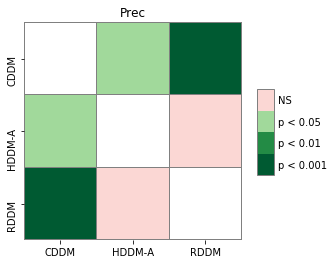

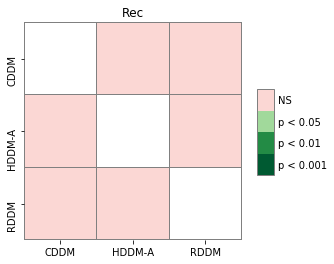

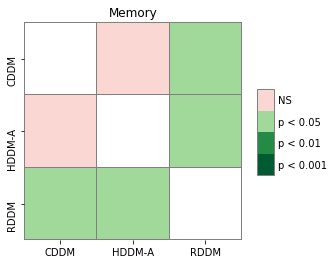

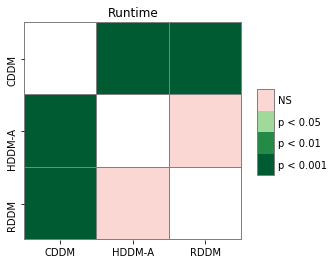

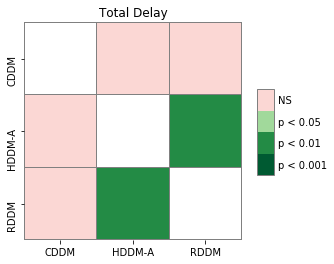

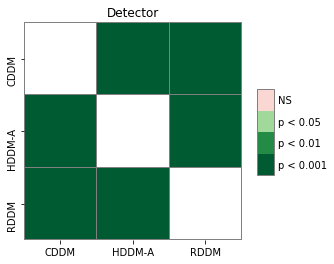

In [74]:
for col in results.columns[1:-1]:
    plt.figure()
#     display(Markdown('## '+col))
    pc = sp.posthoc_nemenyi(results2, val_col=col, group_col='Detector')
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    plt.title(col)
    sp.sign_plot(pc, **heatmap_args);

In [73]:
results2 = results.copy()
# results2 = means_table.groupby(['Detector', 'Model']).mean()
results2['Det+Mod'] = results2['Detector'] + results2['Model']
results2.groupby('Det+Mod').mean()

,Prec,Rec,Memory,Runtime,Total Delay
Det+Mod,,,,,
CDDMNB,0.028789,1.000,10985.269,2470.795,83.9
CDDMPR,0.932143,0.925,3793.126,10462.150,235.5
HDDM-ANB,0.900000,1.000,11100.819,22340.009,165.7
HDDM-APR,0.960000,0.975,3788.703,12737.928,73.2
RDDMNB,0.941667,0.975,11165.291,23285.418,272.1
RDDMPR,1.000000,0.950,3850.188,14304.449,222.9


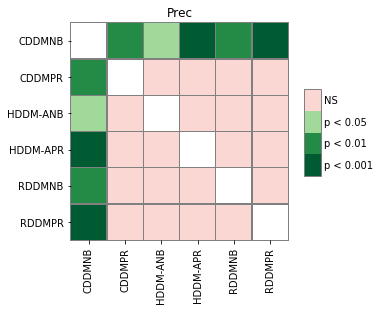

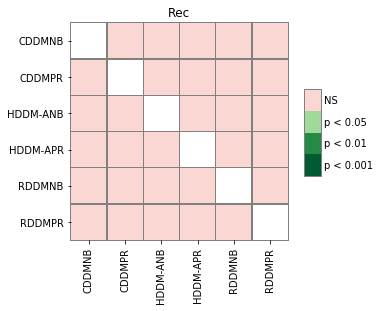

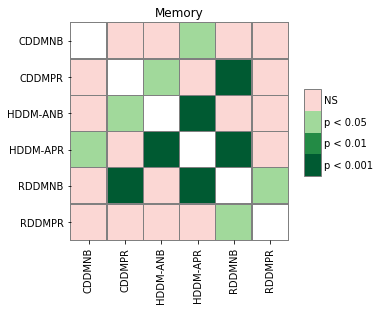

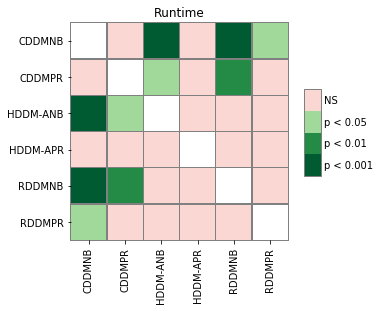

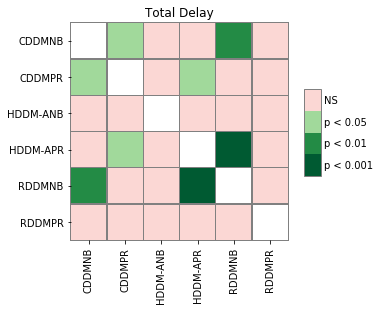

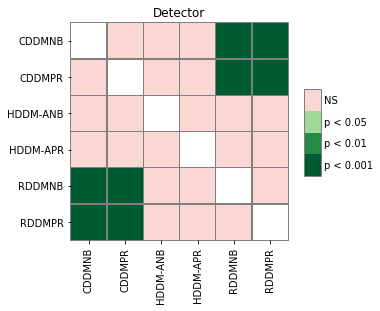

In [71]:
for col in results.columns[1:-1]:
    plt.figure()
#     display(Markdown('## '+col))
    pc = sp.posthoc_nemenyi(results2, val_col=col, group_col='Det+Mod')
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    plt.title(col)
    sp.sign_plot(pc, **heatmap_args);